## CRF

In [5]:
import pandas as pd

# Load the CSV file (adjust encoding if needed)
df = pd.read_csv(r"C:\Users\Tian\Desktop\NLP_Task7\Datasets\NER dataset.csv", encoding='ISO-8859-1')

# Step 1: Fill missing 'Sentence #' by forward filling
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')

# Step 2: Drop any rows with missing values in required columns
df = df.dropna(subset=['Word', 'POS', 'Tag'])

# Step 3: Strip whitespace from strings in all relevant columns
df['Word'] = df['Word'].str.strip()
df['POS'] = df['POS'].str.strip()
df['Tag'] = df['Tag'].str.strip()

# Step 4: Preview the cleaned dataset
print("✅ Cleaned dataset shape:", df.shape)
print(df.head(10))

# Optional: Save cleaned data to new CSV
df.to_csv(r"C:\Users\Tian\Desktop\NLP_Task7\NER_Recog\cleaned_NER_dataset.csv", index=False)

C:\Users\Tian\AppData\Local\Temp\ipykernel_21060\2918627837.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Sentence #'] = df['Sentence #'].fillna(method='ffill')


✅ Cleaned dataset shape: (1048565, 4)
    Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         London  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O


In [6]:
import pandas as pd

# Load the cleaned CSV (already cleaned based on your previous code)
df = pd.read_csv(r"C:\Users\Tian\Desktop\NLP_Task7\NER_Recog\cleaned_NER_dataset.csv")

# Group by sentence
grouped = df.groupby("Sentence #").agg(list)

# Extract sequences
sentences = grouped['Word'].tolist()
ner_tags = grouped['Tag'].tolist()

In [7]:
def word2features(sent, i):
    word = sent[i]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def extract_features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


In [8]:
# Ensure all elements in sentences are valid strings
cleaned_sentences = [[str(word) if not isinstance(word, str) else word for word in sentence] for sentence in sentences]

X = [extract_features(s) for s in cleaned_sentences]  # List of list of dicts
y = ner_tags  # List of list of tags (already done)

In [9]:
# CRF 

import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X, y)  # Training
y_pred = crf.predict(X)  # Prediction


In [10]:
# Evaluate CRF model
print(metrics.flat_classification_report(y, y_pred))


              precision    recall  f1-score   support

       B-art       0.92      0.66      0.77       402
       B-eve       0.85      0.70      0.77       308
       B-geo       0.91      0.95      0.93     37644
       B-gpe       0.98      0.95      0.96     15870
       B-nat       0.92      0.60      0.73       201
       B-org       0.91      0.85      0.88     20143
       B-per       0.95      0.92      0.93     16990
       B-tim       0.96      0.92      0.94     20333
       I-art       0.93      0.76      0.84       297
       I-eve       0.86      0.70      0.77       253
       I-geo       0.91      0.92      0.91      7414
       I-gpe       0.95      0.69      0.80       198
       I-nat       0.90      0.69      0.78        51
       I-org       0.93      0.93      0.93     16784
       I-per       0.94      0.96      0.95     17251
       I-tim       0.93      0.89      0.91      6528
           O       1.00      1.00      1.00    887898

    accuracy              

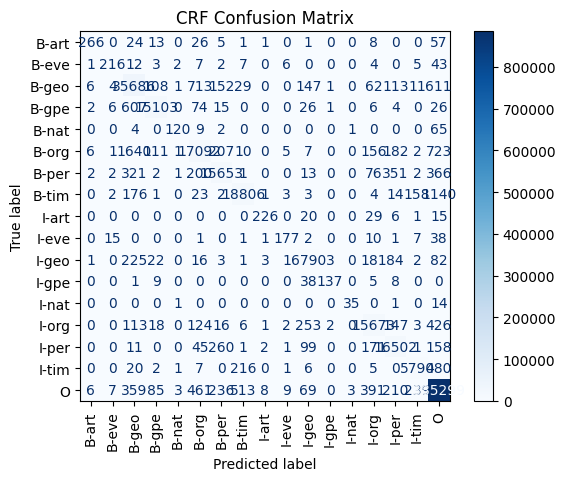

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the sequences for confusion matrix
y_true_flat = [tag for seq in y for tag in seq]
y_pred_flat = [tag for seq in y_pred for tag in seq]
labels = sorted(set(y_true_flat))

# Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("CRF Confusion Matrix")
plt.show()
